### In this markdown , we are extracting data from the wikipedia pages for the programmes launched by Modi government like Swacch Bharat Mission, Digital India, Make in India, Beti padhao beti bachao,startup india using the Wikipedia API . Here, we clean the data , tokenise and lemmatize them using the NLTK libraries. We shuffle the data to get a higher accuray score of the model . 

### Lets go through each of the above mentioned process step by step.

### First step involves scraping data from the wikipage , we are using the wikipedia API to extract the content and after which we are splitting the extracted content by a 'fullstop' (.) or a sentence and adding the extracted data into a csv file.

In [1]:
#Import all the necessary libraries 

#Plotting libraries and basic libraries
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
#Wiki API library
import wikipedia as wiki
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import csv
import requests
import base64

#nltk libbraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from PIL import Image
stop_words = stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS 
#News api 

from newsapi import NewsApiClient

from pprint import pprint
from collections import Counter


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import strip_punctuation, strip_tags, strip_numeric
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings

import gensim
from gensim import corpora
from nltk import FreqDist

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### Set style 

In [2]:
plt.style.use('fivethirtyeight')

### Getting the news api key.

In [3]:

newsapi = NewsApiClient(api_key='42dda698674b406d90874db73b051a09')

In [4]:
# CSV File to write theoutput data 
csv_file = open('NamoNews.csv', 'w', encoding="UTF-8", newline="")

writer = csv.writer(csv_file)

In [5]:
# Write Header row
writer.writerow([ 'Source Id ', 'Source Name', 'Author', 'Title', 'Description', 'Content'])

57

In [6]:
article_dict = {}
for j in range(1,21):
    
    all_articles = newsapi.get_everything(q='swachh bharat',
                                      language='en',
                                      sort_by='relevancy',
                                      page = j )

    articles = all_articles.get('articles')
    
    
    #Each Page has size of 20 
    #Looping through each article and extracting source, author, content,description.
    for i in range(1,len(articles)):
        article = articles[i]
        source = article.get('source')
        source_id = source.get('id')
        source_name = source.get('name')
        
        author = article.get('author')
        title = article.get('title')
        description = article.get('description')
        content = article.get('content')

        article_dict['Source Id '] = source_id
        article_dict['Source Name'] = source_name
        article_dict['Author'] = author
        article_dict['Title'] = title
        article_dict['Description'] = description
        article_dict['Content'] = content
        
        writer.writerow(article_dict.values())


In [7]:
#Close output_api.csv.
csv_file.close()

In [8]:
namo_news = pd.read_csv('NamoNews.csv')

### Now reading Wiki Data for Swachh Bharath and relevant topics

In [9]:
# CSV File to write data 
csv_file = open('sbWiki.csv', 'w', encoding="UTF-8", newline="")
writer = csv.writer(csv_file)

In [10]:
# Write Header row,has two columns Title , Content
writer.writerow([ 'Title', 'Content'])

15

In [11]:
#initialising the dictionary 
corpus_dict = {}
sub_list = []
#Categories to search in the wikipedia page
cat_list = ['Swachh_Bharat_mission','Digital_India','Make_in_India','Beti_Bachao,_Beti_Padhao_Yojana','Startup_India']

for category in cat_list:
    sub_cat = wiki.search(category)
    #sub_cat = wiki.suggest(sugg)
    for  sub in sub_cat:
       # print(sub)
        try:
            page_py = wiki.page(sub)
            cont = page_py.content
            cont = cont.split("\n")
            for item in cont:
                corpus_dict['Title'] = category
                corpus_dict['Content'] = item
                #Writing the data into the csv file.
                writer.writerow(corpus_dict.values())
        except wiki.exceptions.DisambiguationError as e:
              print(e.options)
        except wiki.exceptions.PageError as e:
              print(e)

In [12]:
#Close wiki.csv.
csv_file.close()

###  Next step involves reading the file into a dataframe , and to increase the efficiency of the model we are first splittng the dataframe topic wise and shuffling them and joining them back

In [13]:
#Reading the wikipedia CSV
wikidf = pd.read_csv('sbWiki.csv')

In [14]:
#'Swachh_Bharat_mission','Digital_India','Make_in_India','Beti_Bachao,_Beti_Padhao_Yojana','Startup_India'
df_sbm = wikidf[wikidf['Title'] == 'Swachh_Bharat_mission']
df_di = wikidf[wikidf['Title'] == 'Digital_India']
df_min = wikidf[wikidf['Title'] == 'Make_in_India']
df_bbbp = wikidf[wikidf['Title'] == 'Beti_Bachao,_Beti_Padhao_Yojana']
df_si = wikidf[wikidf['Title'] == 'Startup_India']

In [15]:
df_wiki = [df_sbm,df_di,df_min,df_bbbp,df_si]
wikidf = pd.concat(df_wiki)

In [16]:
from sklearn.utils import shuffle
wikidf = shuffle(wikidf)


### Data cleaning is a very crucial step in this workflow ,  we first clear out the unnecessary punctuations and then tokenize the content. Lemmatizing does the morphological analysis of the words .                NLTK has an inbuilt library WordNetLemmatizer which gets the actual meaning of the tokenized words. 

In [17]:
# Lets put in some cleaning code
def clean_corpus(item):
    item = re.sub('[^ 0-9a-zA-Z]','',item)
    item = re.sub(r' +', ' ', item)
    return item

wnl = WordNetLemmatizer()
def lemmatize_corpus(content):
    row = 0
    for item in content:
        # clean the text
        item = clean_corpus(item)
        lines = ""
        for i, j in pos_tag(word_tokenize(item)):
            word = ''
            if j[0].lower() in ['n', 'v', 'r']:
                word = wnl.lemmatize(i, j[0].lower())
            elif j[0].lower() is 'j':
                word = wnl.lemmatize(i, 'a')
            else:
                word = wnl.lemmatize(i)
            lines = lines + " " + word.lower()
        content[row] = lines
        row = row + 1;

    return content

### Removing the nan's from the content

In [18]:
wikidf['Content'].replace('', np.nan, inplace=True)
wikidf.dropna(subset=['Content'], inplace=True)

### Reseting the index to increase readability

In [19]:
df = wikidf.reset_index(drop=True)

### Calling the cleaning method on the Content of the extracted data

In [20]:
df['Content'] = lemmatize_corpus(df['Content'])
df.head()

,Title,Content
0,Startup_India,conversion to highspeed corridor
1,Digital_India,patient would be provide a number key which t...
2,Swachh_Bharat_mission,the ministry of urban development government ...
3,Swachh_Bharat_mission,idfoi have collect over 88 project from 15 st...
4,Startup_India,t app folio


### Let's Find out key-words for this initiaves:

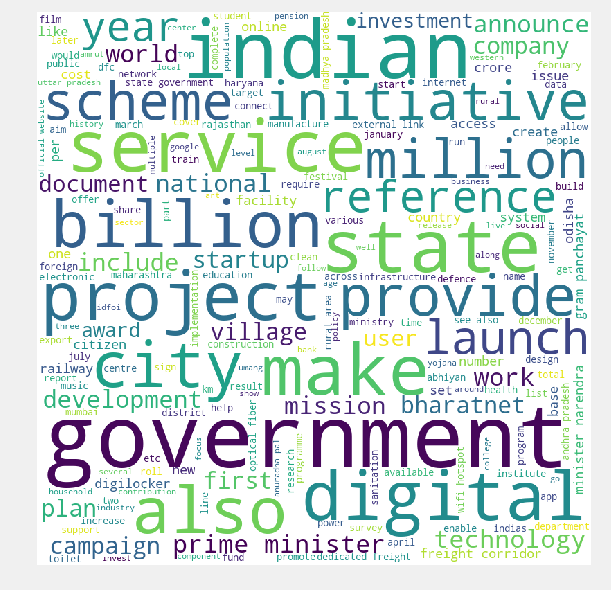

In [21]:
comment_words = ' '
stop_words.extend(['modi', 'narendramodi', 'abhiyaan', 'india','edu', 'use','i','as','of','the','is','a','in','ur','http','swachh','swachhbharat','twitter','bharat'])
tokens=''
for val in df.Content: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words=str(comment_words)+str(words)+' '

wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10).generate(comment_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# For swachha bharat abhiyan:

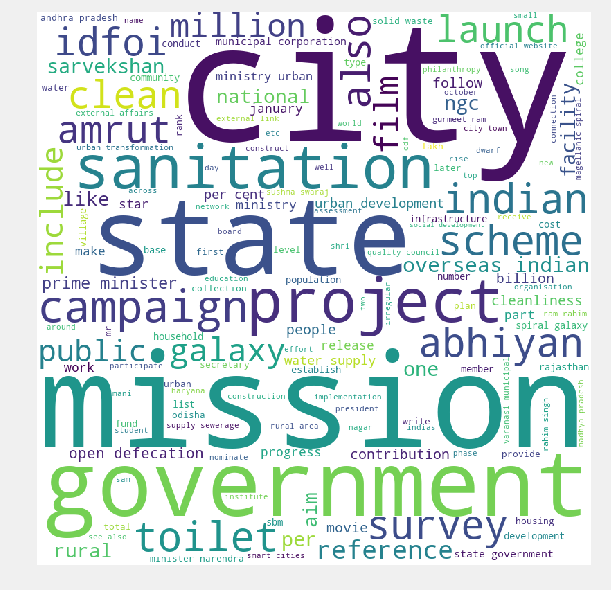

In [22]:
comment_words = ' '
stop_words.extend(['modi', 'narendramodi', 'abhiyaan', 'india','edu', 'use','i','as','of','the','is','a','in','http','swachh','swachhbharat','twitter','bharat'])

df1=df[df['Title']=='Swachh_Bharat_mission']
tokens=''
for val in df1.Content: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words=str(comment_words)+str(words)+' '

wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10).generate(comment_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [23]:
df = shuffle(df)

In [24]:
vectorizer = CountVectorizer(min_df = 0.01,max_df= 0.99, stop_words="english")
features = pd.DataFrame(vectorizer.fit_transform(df['Content']).toarray(),columns=vectorizer.get_feature_names())
features.head()

,10,100,12,15,2011,2014,2015,2016,2017,2018,...,water,website,west,wifi,woman,work,world,worth,year,yojana
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, df['Title'],test_size=0.30)

In [26]:
# model 1 - Random forest Count Vectorizer
model1 = RandomForestClassifier()
model1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
pred1 = model1.predict(X_test)

In [28]:
model1_score = model1.score(X_test,y_test)
print("CLASSIFICATION REPORT: \n\n",classification_report(y_test,pred1))
print("RANDOM FOREST CLASSIFIER SCORE : " ,model1_score)

CLASSIFICATION REPORT: 

                                  precision    recall  f1-score   support

Beti_Bachao,_Beti_Padhao_Yojana       0.50      0.30      0.38        46
                  Digital_India       0.20      0.14      0.16        43
                  Make_in_India       0.43      0.55      0.48        55
                  Startup_India       0.38      0.31      0.34        64
          Swachh_Bharat_mission       0.40      0.56      0.47        66

                      micro avg       0.39      0.39      0.39       274
                      macro avg       0.38      0.37      0.37       274
                   weighted avg       0.39      0.39      0.38       274

RANDOM FOREST CLASSIFIER SCORE :  0.3905109489051095


In [29]:
#Model 2 LogisticRegression Count Vectorizer
X_train, X_test, y_train, y_test = train_test_split(features, df['Title'],test_size=0.30)
model2 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

In [30]:
model2.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
pred2 = model2.predict(X_test)

In [32]:
model2_score = model2.score(X_test,y_test)
print("CLASSIFICATION REPORT: \n\n",classification_report(y_test,pred2))
print("LOGISTIC REGRESSION SCORE : " ,model2_score)

CLASSIFICATION REPORT: 

                                  precision    recall  f1-score   support

Beti_Bachao,_Beti_Padhao_Yojana       0.57      0.36      0.44        45
                  Digital_India       0.56      0.33      0.41        46
                  Make_in_India       0.51      0.67      0.58        60
                  Startup_India       0.39      0.39      0.39        57
          Swachh_Bharat_mission       0.52      0.67      0.59        66

                      micro avg       0.50      0.50      0.50       274
                      macro avg       0.51      0.48      0.48       274
                   weighted avg       0.51      0.50      0.49       274

LOGISTIC REGRESSION SCORE :  0.5


# TF-IDF Vectorizer

In [33]:
tfidfvectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf_featr = pd.DataFrame(tfidfvectorizer.fit_transform(df['Content']).toarray(),columns=tfidfvectorizer.get_feature_names())

In [34]:
tfidf_featr.head()

,04,06,10,100,1000,10000,100000,100000000,100mbps,100th,...,zadar,zakir,zero,zila,zippserv,zippservs,zonal,zone,zte,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#Model3 Logistic Regression (TF-IDF)
X_train, X_test, y_train, y_test = train_test_split(tfidf_featr, df['Title'],test_size=0.30)
model3 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

model3.fit(X_train,y_train)

pred3 = model3.predict(X_test)

In [36]:
model3_score = model3.score(X_test,y_test)
print("CLASSIFICATION REPORT: \n\n",classification_report(y_test,pred3))
print("LOGISTIC REGRESSION SCORE : " ,model3_score)

CLASSIFICATION REPORT: 

                                  precision    recall  f1-score   support

Beti_Bachao,_Beti_Padhao_Yojana       0.72      0.47      0.57        45
                  Digital_India       0.46      0.30      0.36        37
                  Make_in_India       0.54      0.75      0.63        68
                  Startup_India       0.37      0.52      0.43        56
          Swachh_Bharat_mission       0.83      0.59      0.69        68

                      micro avg       0.55      0.55      0.55       274
                      macro avg       0.59      0.52      0.54       274
                   weighted avg       0.60      0.55      0.56       274

LOGISTIC REGRESSION SCORE :  0.5547445255474452


# Model 4 Random forest(TF-IDF)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_featr, df['Title'],test_size=0.30)
model4 = RandomForestClassifier()
model4.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
pred4 = model4.predict(X_test)

In [39]:
model4_score = model4.score(X_test,y_test)
print("CLASSIFICATION REPORT: \n\n",classification_report(y_test,pred4))
print("RANDOM FOREST CLASSIFIER SCORE : " ,model4_score)

CLASSIFICATION REPORT: 

                                  precision    recall  f1-score   support

Beti_Bachao,_Beti_Padhao_Yojana       0.52      0.31      0.39        51
                  Digital_India       0.12      0.22      0.15        27
                  Make_in_India       0.69      0.39      0.50        75
                  Startup_India       0.56      0.32      0.41        59
          Swachh_Bharat_mission       0.41      0.76      0.53        62

                      micro avg       0.43      0.43      0.43       274
                      macro avg       0.46      0.40      0.40       274
                   weighted avg       0.51      0.43      0.43       274

RANDOM FOREST CLASSIFIER SCORE :  0.42700729927007297


In [40]:
score3 = ("{0:.0%}".format(model3_score))
score4 = ("{0:.0%}".format(model4_score))
print("Scores using TF-IDF Vectorizer :\n")
print("Random Forest     Logistic Regression:\n")
print(score4,"            ",score3)

Scores using TF-IDF Vectorizer :

Random Forest     Logistic Regression:

43%              55%


In [41]:
client_key = 'YQIKnk4Uo4D0fuXUSHNJRhWHe'
client_secret = '8QIsFmbDjfNl3x0ihWbpmggV5RLwpMuLaZdQxo84cAgXlQQuZr'

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

In [42]:
base_url = 'https://api.twitter.com/'
auth_url = '{}oauth2/token'.format(base_url)
auth_headers = {
    'Authorization': 'Basic {}'.format(b64_encoded_key),
    'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
}
auth_data = {
    'grant_type': 'client_credentials'
}
auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)

In [43]:
auth_resp.status_code
auth_resp.json().keys()
access_token = auth_resp.json()['access_token']

In [ ]:
search_headers = {
    'Authorization': 'Bearer {}'.format(access_token)    
}
search_url = "https://api.twitter.com/1.1/tweets/search/30day/NamoAn.json?query=%23swachhbharat%20India%20lang%3Aen&maxResults=100&fromDate=201812220000&toDate=201812230000"
search_resp = requests.get(search_url, headers=search_headers)
tweet_data = search_resp.json()
tweet_data_res = tweet_data.get('results')
tweet_data_res

In [54]:
len(tweet_data_res)

61

In [55]:
# CSV File to write theoutput data 
csv_file = open('Namo_hist_Recent2018.csv', 'w', encoding="UTF-8", newline="")

writer = csv.writer(csv_file)
# Write Header row
writer.writerow(['User','Created_At','Tweet_text','Location','hashtags','mentions'])
hist_data_dict = {}
for i in range(0,len(tweet_data_res)):
        res = tweet_data_res[i]
        text = res.get('text')
        created_at = res.get('created_at')
        
        extended_tweet = res.get('extended_tweet')
        
        scr_name = res.get('screen_name')
        user_profile = res.get('user')
       
        user_name = user_profile.get('name')
        location = user_profile.get('location')
        
       
        hist_data_dict['User'] = user_name
       
        hist_data_dict['Created_at'] = created_at
        hist_data_dict['Tweet_Text'] = text
        hist_data_dict['Location'] = location
        entites = res.get('entities')
        #print(entites)
        if(entites is not None):
            hashtags = entites.get('hashtags')
        
            hist_data_dict['hashtags'] = hashtags
            #print(hashtags)
            user_tags = entites.get('user_mentions')
            mentions = user_tags         
            hist_data_dict['mentions'] = mentions
        writer.writerow(hist_data_dict.values())
       
#Close output_api.csv.
csv_file.close()

In [56]:
swachh1 = pd.read_csv('Namo_hist_Dec2014.csv',error_bad_lines=False)
swachh2 = pd.read_csv('Namo_hist_Jan2015.csv',error_bad_lines=False)
swachh3 = pd.read_csv('Namo_hist_Nov2014.csv',error_bad_lines=False)
swachh4 = pd.read_csv('Namo_hist_Feb2015.csv',error_bad_lines=False)
swachh5 = pd.read_csv('Namo_hist_Mar2015.csv',error_bad_lines=False)
swachh6 = pd.read_csv('Namo_hist_Apr2015.csv',error_bad_lines=False)
swachh7 = pd.read_csv('Namo_hist_May2015.csv',error_bad_lines=False)
swachh8 = pd.read_csv('Namo_hist_Jun2015.csv',error_bad_lines=False)
swachh9 = pd.read_csv('Namo_hist_Jun032015.csv',error_bad_lines=False)
swachh10 = pd.read_csv('Namo_hist_Jul2015.csv',error_bad_lines=False)
swachh11 = pd.read_csv('Namo_hist_Aug2015.csv',error_bad_lines=False)
swachh12 = pd.read_csv('Namo_hist_Sep2015.csv',error_bad_lines=False)
swachh13 = pd.read_csv('Namo_hist_Oct2015.csv',error_bad_lines=False)
swachh14 = pd.read_csv('Namo_hist_Nov2015.csv',error_bad_lines=False)
swachh15 = pd.read_csv('Namo_hist_Dec2015.csv',error_bad_lines=False)
swachh16 = pd.read_csv('Namo_hist_Jan2016.csv',error_bad_lines=False)
swachh17 = pd.read_csv('Namo_hist_Feb2016.csv',error_bad_lines=False)
swachh18 = pd.read_csv('Namo_hist_Mar2016.csv',error_bad_lines=False)
swachh19 = pd.read_csv('Namo_hist_Apr2016.csv',error_bad_lines=False)
swachh20 = pd.read_csv('Namo_hist_Recent2018.csv',error_bad_lines=False)


In [57]:
swachh_bharath = pd.concat([swachh1,swachh2,swachh3,swachh4,swachh5,swachh6,swachh7,swachh8,swachh9,swachh10,swachh11,swachh12
                            ,swachh12,swachh13,swachh14,swachh15,swachh16,swachh17,swachh18,swachh19,swachh20])


<Figure size 576x576 with 0 Axes>

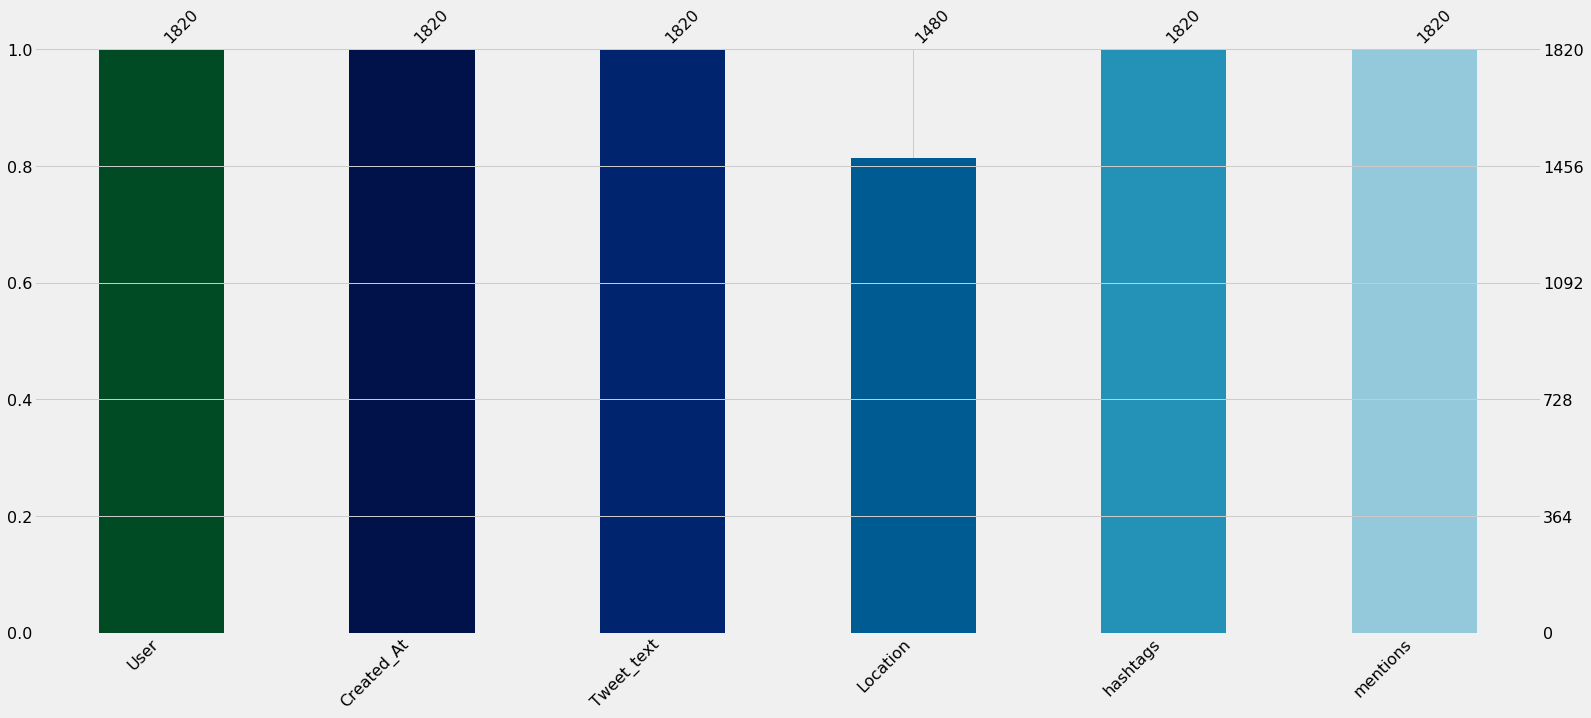

In [58]:
plt.figure(figsize=(8,8))
msno.bar(swachh_bharath,color= sns.color_palette('ocean'))

In [59]:
swachh_bharath.head()

,User,Created_At,Tweet_text,Location,hashtags,mentions
0,HS,Tue Dec 30 19:08:58 +0000 2014,@narendramodi Isn't it equally imp for india?...,NaN,"[{'text': 'SwachhBharat', 'indices': [74, 87]}]","[{'screen_name': 'narendramodi', 'name': 'Nare..."
1,DIPAK K DALAL,Tue Dec 30 18:33:15 +0000 2014,"RT @M_Lekhi: At EPC World Awards,India InfraFo...","Bapunagar, Ahmadabad City","[{'text': 'SwachhBharat', 'indices': [92, 105]}]","[{'screen_name': 'M_Lekhi', 'name': 'Meenakash..."
2,Sharjeel,Tue Dec 30 16:41:57 +0000 2014,RT @rkhuria: Real seeds of #swachhbharat have ...,"Hyderabad, India","[{'text': 'swachhbharat', 'indices': [27, 40]}]","[{'screen_name': 'rkhuria', 'name': 'RKHURIA',..."
3,Yunus Lasania,Tue Dec 30 13:57:47 +0000 2014,RT @rkhuria: Real seeds of #swachhbharat have ...,Hyderabad,"[{'text': 'swachhbharat', 'indices': [27, 40]}]","[{'screen_name': 'rkhuria', 'name': 'RKHURIA',..."
4,Prof. Y K Singh,Tue Dec 30 13:49:25 +0000 2014,RT @rkhuria: Real seeds of #swachhbharat have ...,"Chandigarh,Varanasi","[{'text': 'swachhbharat', 'indices': [27, 40]}]","[{'screen_name': 'rkhuria', 'name': 'RKHURIA',..."


In [60]:
swachh_bharath.sort_values("Tweet_text", inplace = True) 
  # dropping ALL duplicte values 
swachh_bharath.drop_duplicates(subset ="Tweet_text",keep = 'last', inplace = True) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 769 entries, 87 to 11
Data columns (total 6 columns):
User          769 non-null object
Created_At    769 non-null object
Tweet_text    769 non-null object
Location      663 non-null object
hashtags      769 non-null object
mentions      769 non-null object
dtypes: object(6)
memory usage: 42.1+ KB


In [61]:
#Removing the nan's from the content
swachh_bharath['Tweet_text'].replace('', np.nan, inplace=True)
swachh_bharath.dropna(subset=['Tweet_text'], inplace=True)

In [123]:
#Reseting the index to increase readability
sbdf = swachh_bharath.reset_index(drop=True)

In [124]:
def remove_nouns(sentence):
    #Removing URL's
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', sentence, flags=re.MULTILINE)
    #Removing nouns
    tagged_sentence = nltk.tag.pos_tag(text.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    edited_sentence = ' '.join(map(str, edited_sentence))
    return edited_sentence
sbdf['Tweet_text'] = sbdf['Tweet_text'].apply(remove_nouns)

In [125]:
lemma = WordNetLemmatizer()
# NLTK Stop words extended
stop_words.extend(['modi', 'narendramodi', 'abhiyaan', 'india','edu', 'use','i','as','of','ur','the','is','a','in','http','swachh','swachhbharat','twitter','bharat'])
def textClean(text0):
    text1 = [strip_punctuation(doc) for doc in text0]
    text1 = [strip_tags(doc) for doc in text1]
    text1 = [strip_numeric(doc) for doc in text1]
    text1 = [[" ".join([i for i in doc.lower().split() if i not in stop_words])] for doc in text1]
    text2 = [[word for word in ' '.join(doc).split()] for doc in text1]
    normalized = [[" ".join([lemma.lemmatize(word) for word in ' '.join(doc).split()])] for doc in text1]
    return normalized

In [126]:
# Calling the cleaning method on the Content of the extracted data

sbdf['cleanedText'] = textClean(sbdf['Tweet_text'])
#sbdf.head()
corpus1 = textClean(sbdf['Tweet_text'])  # corpus cleaned of html tags, puncs, lemmas

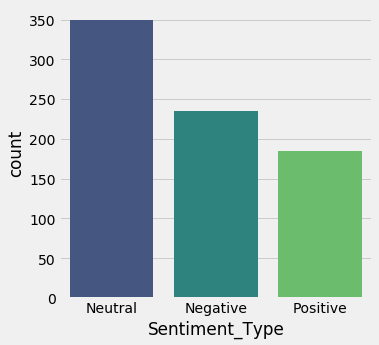

In [67]:
from textblob import TextBlob
import seaborn as sns

bloblist_desc = list()
df= sbdf['cleanedText'].astype(str)

for row in df:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    

def f(df_desc):
    if df_desc['sentiment'] > 0:
        val = "Positive"
    elif df_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

df_desc['Sentiment_Type'] = df_desc.apply(f, axis=1)
plt.figure(figsize=(5,5))
ax = sns.countplot(x="Sentiment_Type", data=df_desc,palette='viridis')

In [68]:
df_pos_sentiment = df_desc[df_desc['Sentiment_Type'] == 'Positive']
df_neg_sentiment = df_desc[df_desc['Sentiment_Type'] == 'Negative']


In [69]:
df_neg_sentiment['sentiment'] = round(df_neg_sentiment['sentiment'],2)
df_pos_sentiment['sentiment'] = round(df_pos_sentiment['sentiment'],2)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

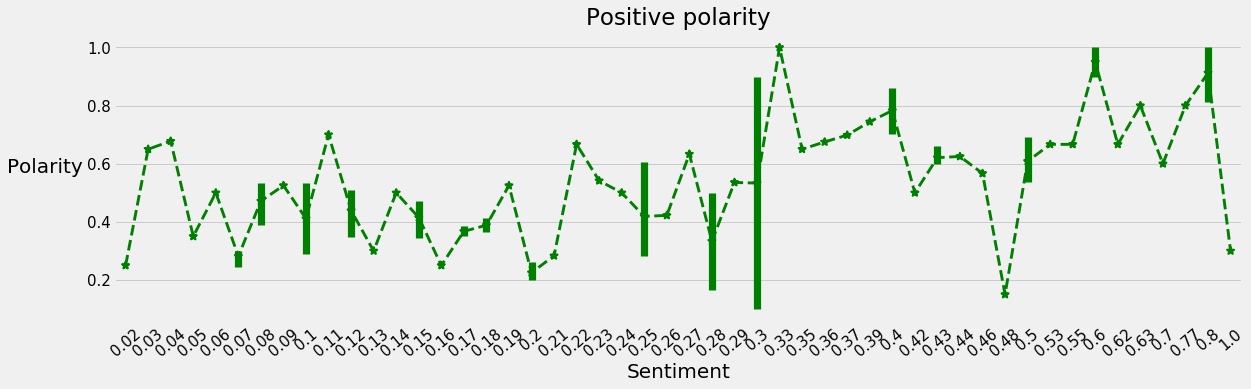

In [70]:
#df_pos_sentiment['polarity'] = round_float(df_pos_sentiment['polarity'])
fig = plt.figure(figsize = (18,5))
sns.pointplot(df_pos_sentiment['sentiment'],df_pos_sentiment['polarity'],linestyles='--',scale = 0.4,color = 'green',markers = '*')
plt.xlabel("Sentiment",rotation = 'horizontal',fontsize = 20)
plt.ylabel("Polarity",rotation = 'horizontal',horizontalalignment = 'right',fontsize = 20)
plt.title("Positive polarity",fontsize = 23)
plt.xticks(rotation=40,fontsize = 15)
plt.yticks(fontsize = 15)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

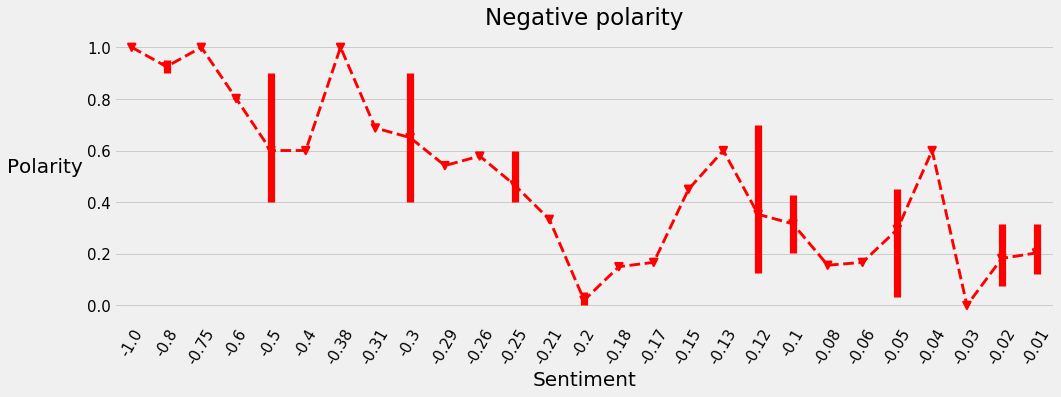

In [71]:
#df_pos_sentiment['polarity'] = round_float(df_pos_sentiment['polarity'])
fig = plt.figure(figsize = (15,5))
sns.pointplot(df_neg_sentiment['sentiment'],df_neg_sentiment['polarity'],linestyles='--',scale = 0.4,color = 'red',markers = 'v')
plt.xlabel("Sentiment",rotation = 'horizontal',fontsize = 20)
plt.ylabel("Polarity",rotation = 'horizontal',horizontalalignment = 'right',fontsize = 20)
plt.title("Negative polarity",fontsize = 23)
plt.xticks(rotation=60,fontsize = 15)
plt.yticks(fontsize = 15)

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 9 Text yticklabel objects>)

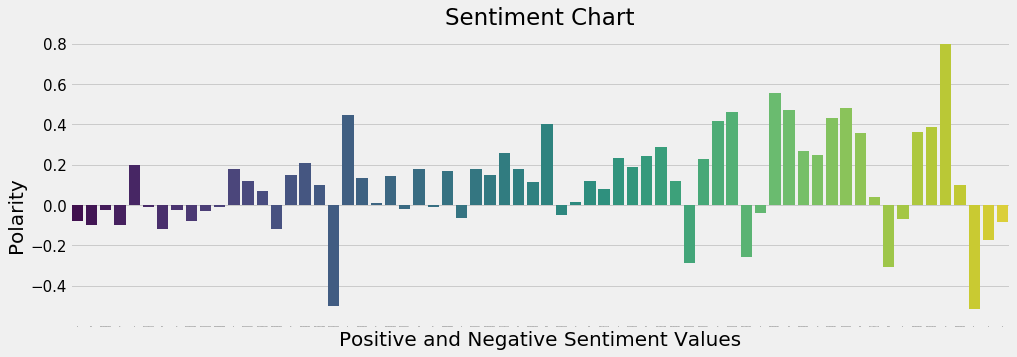

In [72]:
df_sentiment = pd.concat([df_pos_sentiment,df_neg_sentiment])
#df_pos_sentiment['polarity'] = round_float(df_pos_sentiment['polarity'])
fig = plt.figure(figsize = (15,5))
sns.barplot(df_sentiment['polarity'],df_sentiment['sentiment'],palette='viridis',ci = None)
plt.xlabel("Positive and Negative Sentiment Values",rotation = 'horizontal',fontsize = 20)
plt.ylabel("Polarity",rotation = 'vertical',horizontalalignment = 'right',fontsize = 20)
plt.title("Sentiment Chart",fontsize = 23)
plt.xticks(fontsize = -0.5)
plt.yticks(fontsize = 15)

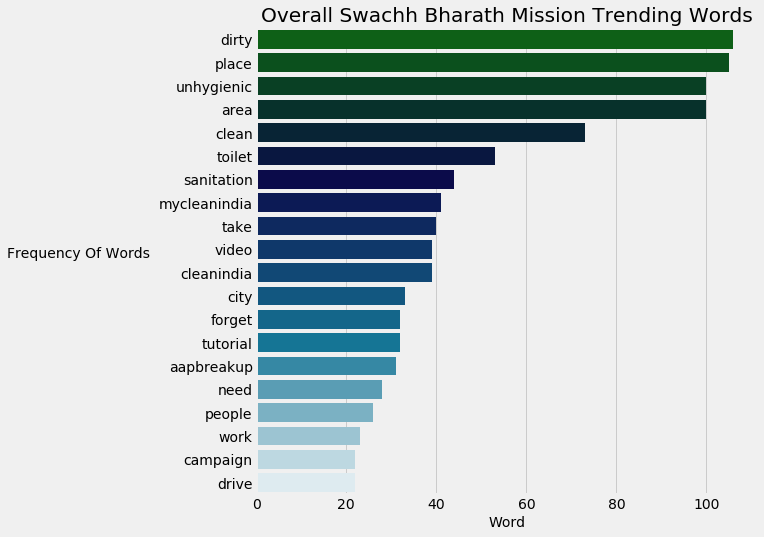

In [73]:
top_N = 20
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

sentence = df_desc['sentence'].astype(str)
sentence = sentence.str.cat(sep=' ')
# removes punctuation,numbers and returns list of words
clean_sen = re.sub('[^A-Za-z]+', ' ', sentence)

word_tokens = word_tokenize(clean_sen)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
# Remove characters which have length less than 3 
without_single_chr = [word for word in filtered_sentence if len(word) > 3]

# Remove numbers
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data)
res = pd.DataFrame(word_dist.most_common(top_N),columns=['Word', 'Frequency'])

plt.figure(figsize=(8,8))
ax = sns.barplot(x=res['Frequency'],y=res["Word"],palette= 'ocean')
plt.xlabel("Word",fontsize = 14)
plt.ylabel("Frequency Of Words ",rotation = 'horizontal',fontsize = 14,horizontalalignment = 'right')
plt.title("Overall Swachh Bharath Mission Trending Words")

word_dist = nltk.FreqDist(res['Word'])
res = pd.DataFrame(word_dist.most_common(top_N),columns=['Word', 'Frequency'])



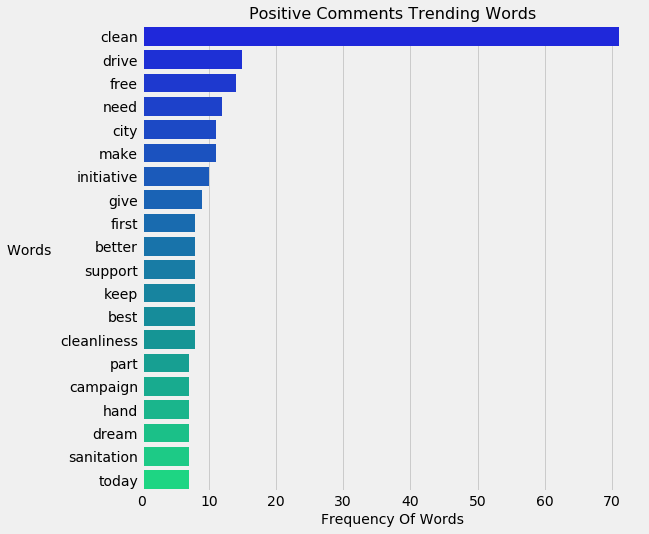

In [74]:
top_N = 20
#convert list of list into text

a = df_pos_sentiment['sentence'].astype(str)
a = a.str.cat(sep=' ')
# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 3]

# Remove numbers
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data)
res = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])

plt.figure(figsize=(8,8))
ax = sns.barplot(x=res['Frequency'],y=res["Word"],palette= 'winter')
plt.xlabel("Frequency Of Words",fontsize = 14)
plt.ylabel("Words ",rotation = 'horizontal',fontsize = 14,horizontalalignment = 'right')
plt.title("Positive Comments Trending Words",fontsize = 16)


word_dist = nltk.FreqDist(res['Word'])
res = pd.DataFrame(word_dist.most_common(top_N),columns=['Word', 'Frequency'])



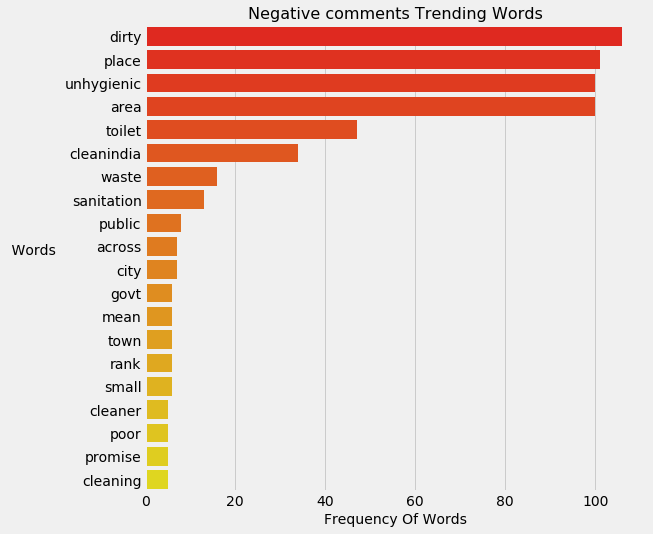

In [75]:
top_N = 20
#convert list of list into text


sent = df_neg_sentiment['sentence'].astype(str)
sent = sent.str.cat(sep=' ')
# removes punctuation,numbers and returns list of words
word_list = re.sub('[^A-Za-z]+', ' ', sent)

#remove all the stopwords from the text


word_tokens = word_tokenize(word_list)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 3]

# Remove numbers
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data)
res = pd.DataFrame(word_dist.most_common(top_N),columns=['Word', 'Frequency'])

plt.figure(figsize=(8,8))
ax = sns.barplot(x=res['Frequency'],y=res["Word"],palette= 'autumn')
plt.xlabel("Frequency Of Words",fontsize = 14)
plt.ylabel(" Words ",rotation = 'horizontal',fontsize = 14,horizontalalignment = 'right')
plt.title("Negative comments Trending Words",fontsize = 16)


word_dist = nltk.FreqDist(res['Word'])
res = pd.DataFrame(word_dist.most_common(top_N),columns=['Word', 'Frequency'])



### Retreiving Hashtags and monitoring the trending topics related to Swachh Bharath

In [76]:
hashtag_list = []
import string
for i in swachh_bharath['hashtags']:
    text_split = i.split('text')
    for txt in text_split:
       
        indices = re.sub("[\(\[].*?[\)\]]", "", txt)
        
        indices_split = indices.split('indices')
        
        for strg in indices_split:
            out= strip_punctuation(strg)
            out = out.strip(' ')
            out = out.lower()
            hashtag_list.append(out)  
            

str_list = list(filter(None, hashtag_list))


In [77]:
hash_df = pd.DataFrame(columns=['HashTags'],data = str_list)


## Lets see what we get!!

Text(0.5,1,'Top 20 Trending Hashtags')

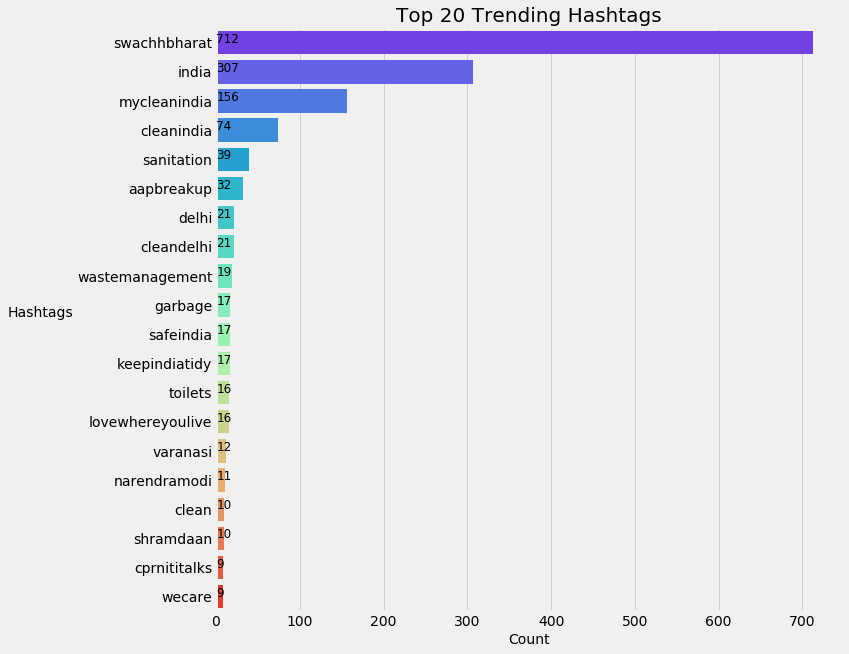

In [78]:

plt.figure(figsize=(10,10))
count = hash_df.HashTags.value_counts()[:20]
sns.barplot(count.values, count.index,palette='rainbow',errwidth=0.5)
for i, v in enumerate(count.values):
    plt.text(0.5,i,v,fontsize=12)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Hashtags', fontsize=14,rotation = 'horizontal',horizontalalignment = 'right')
plt.title("Top 20 Trending Hashtags", fontsize=20)


In [159]:
#sbdf['Location'] = sbdf['Location'].astype(str).apply(lambda x : x.split(','))
# new data frame with split value columns 
new = sbdf['Location'].str.split(",",expand = True) 

# making seperate first name column from new data frame 
sbdf["City"]= new[0]
# making seperate last name column from new data frame 
sbdf["Country"]= new[1] 

In [168]:
sbdf['City'] = sbdf['City'].fillna('India')
for i,v in enumerate(sbdf['City']):
    value = str(v).lower()
    if value == 'india':
        sbdf['City'].iloc[i] = 'India'
    elif value == '#india':
         sbdf['City'].iloc[i] = 'India'
    elif value == 'bharath':
         sbdf['City'].iloc[i] = 'India'
    elif value == 'bangalore':
         sbdf['City'].iloc[i] = 'Bengaluru'
    else:
        sbdf['City'].iloc[i] = value.capitalize()
      

Text(0.5,1,'Top 20 Tweet Locations for Swachh Bharath')

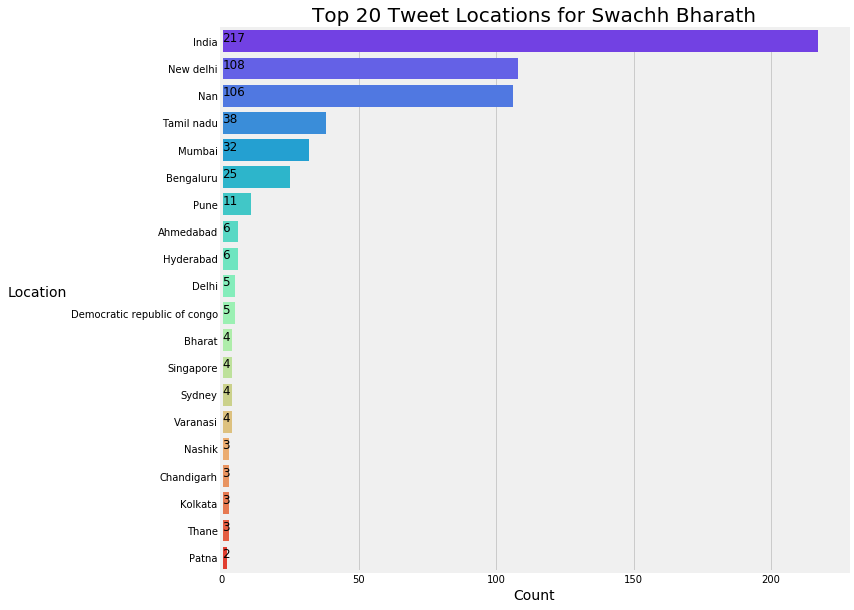

In [167]:
plt.figure(figsize=(10,10))
count = sbdf.City.value_counts()[:20]
sns.barplot(count.values, count.index,palette='rainbow',errwidth=0.5)
for i, v in enumerate(count.values):
    plt.text(0.5,i,v,fontsize=12)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Location', fontsize=14,rotation = 'horizontal',horizontalalignment = 'right')
plt.title("Top 20 Tweet Locations for Swachh Bharath", fontsize=20)

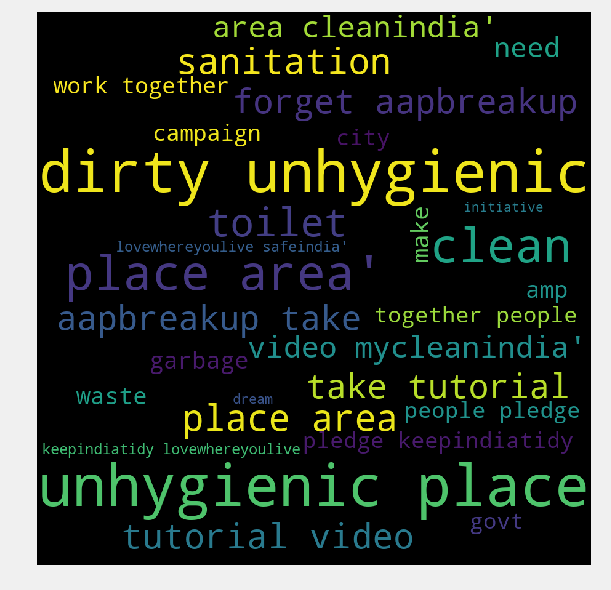

In [79]:
comment_words = ' '

tokens=''
for val in df_desc['sentence']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words=str(comment_words)+str(words)+' '

wordcloud = WordCloud(width = 900, height = 900,background_color ='black',stopwords = stop_words,min_font_size = 20).generate(comment_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [80]:
## Document Term Matrix  building  using gensim
corpus2 = [[word for word in ' '.join(doc).split()] for doc in corpus1]  # word_tokenize first

# Building the bigram and trigram models
bigram = gensim.models.Phrases(corpus2, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[corpus2], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# print(trigram_mod[bigram_mod[corpus2[0]]])  # See trigram example

id2word = corpora.Dictionary(corpus2)  # Create Dictionary
corpus = [id2word.doc2bow(text) for text in corpus2]  # Building gensim corpus. TF DTM creation.
print(corpus[:10])  # View one doc in abstract form

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)], [(33, 1), (34, 1), (35, 1)], [(25, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)], [(41, 1), (42, 1), (43, 1), (44, 1)], [(45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]]


In [81]:
# Build LDA model for 5 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [82]:
def beta_bld_df(lda_model=lda_model, id2word=id2word):
    beta = lda_model.get_topics()  # shape (num_topics, vocabulary_size).
    beta_df = pd.DataFrame(data=beta)

    # convert colnames in beta_df 2 tokens
    token2col = list(id2word.token2id)
    beta_df.columns = token2col
    
    # convert rownames too, eh? Using format(), .shape[] and range()
    rowNames=['topic' + format(x+1, '02d') for x in range(beta_df.shape[0])]
    rowNames_series = pd.Series(rowNames)
    beta_df.rename(index=rowNames_series, inplace=True)
    return(beta_df)

# invoke func
beta_df = beta_bld_df(lda_model=lda_model, id2word=id2word)
beta_df.iloc[:8, :8]

,built,lakh,loo,month,village,human,inwords,life
topic01,0.000218,0.000218,0.000218,0.000218,0.000230,0.000694,0.000218,0.000218
topic02,0.009137,0.004237,0.002152,0.003082,0.004569,0.003835,0.000393,0.002952
topic03,0.000185,0.000193,0.000185,0.000185,0.000185,0.000185,0.000185,0.000187
topic04,0.000166,0.000165,0.000165,0.000166,0.000172,0.000165,0.000165,0.000165
topic05,0.000133,0.000134,0.000133,0.000133,0.000143,0.000136,0.000133,0.000134


In [83]:
# func to get gamma matrix by looping using list.comp
def build_gamma_df(lda_model, corpus0):
    gamma_doc = []  # empty list 2 populate with gamma colms
    num_topics = lda_model.get_topics().shape[0]
    
    for doc in range(len(corpus0)):
        doc1 = corpus0[doc].split()
        bow_doc = id2word.doc2bow(doc1)
        gamma_doc0 = [0]*num_topics  # define list of zeroes num_topics long
        gamma_doc1 = lda_model.get_document_topics(bow_doc)
        gamma_doc2_x = [x for (x,y) in gamma_doc1]#; gamma_doc2_x
        gamma_doc2_y = [y for (x,y) in gamma_doc1]#; gamma_doc2_y
        for i in range(len(gamma_doc1)):
            x = gamma_doc2_x[i]
            y = gamma_doc2_y[i]
            gamma_doc0[x] = y  # wasn't geting this in list comprehension somehow 
        gamma_doc.append(gamma_doc0)
        
    gamma_df = pd.DataFrame(data=gamma_doc)  # shape=num_docs x num_topics
    topicNames=['topic' + format(x+1, '02d') for x in range(num_topics)]
    topicNames_series = pd.Series(topicNames)
    gamma_df.rename(columns=topicNames_series, inplace=True)
    return(gamma_df)

# now apply func
gamma_df = build_gamma_df(lda_model=lda_model, corpus0=sbdf['Tweet_text'])
gamma_df.iloc[:8, :]

,topic01,topic02,topic03,topic04,topic05
0,0.033303,0.852453,0.031164,0.034880,0.048200
1,0.056108,0.751416,0.052504,0.058766,0.081206
2,0.056108,0.066644,0.052504,0.058766,0.765978
3,0.015006,0.933517,0.014042,0.015717,0.021719
4,0.023679,0.605595,0.022158,0.314228,0.034341
5,0.915163,0.021820,0.017190,0.019240,0.026587
6,0.056108,0.066644,0.052504,0.058766,0.765978
7,0.033303,0.852453,0.031164,0.034880,0.048200


In [84]:
gamma_df.iloc[2,:].sum() 

1.0000000037252903

In [85]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # model fit metric. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.058177044477893

Coherence Score:  nan


In [86]:
## compute coherence score (akin to LMD?)
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    
    coherence_values = []
    model_list = []
    num_topics1 = [i for i in range(start, limit, step)]
    for num_topics in num_topics1:
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100,
                                           update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values  # note, list of 2 objs returned

In [87]:
# Can take a long time to run.
start1=2
limit1=10
step1=1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=corpus2, start=start1, limit=limit1, step=step1)

print(coherence_values)

[0.526411025134002, 0.5428171237747454, 0.5583318179931976, 0.5608806154318184, 0.554541543048124, 0.584762150602938, 0.5825648005658469, 0.5838465662733284]


In [88]:
# obtain optimal topic number
coher = list(enumerate(coherence_values))  # create an index for each list elem
index_max = [x for (x,y) in coher if y==max(coherence_values)]  # obtain index num corres to max coherence value
Optimal_numTopics = int(str(index_max[0]))  # convert that list elem into integer (int()) via string (str())
print(Optimal_numTopics)

5


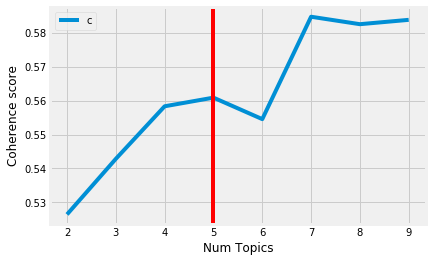

In [89]:
## Plot the change in coherence score with num_topics
import matplotlib.pyplot as plt
%matplotlib inline

start1=2
limit1=10
step1=1
# Show graph
x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=Optimal_numTopics, color='r')
plt.show()

In [90]:
len(model_list)

8

In [91]:
## compute perplexity fit
def compute_perplexity_values(model_list, corpus, start, limit, step):
    perplexity_values = []
    for num_topics in range(start, limit, step):
        
        model_index = num_topics - start
        model = model_list[model_index]
        perplexity_values.append(model.log_perplexity(corpus))
        #model_list.append(model)
        

    return perplexity_values  # note, list of 2 objs returned

# Can take a long time to run.
# perplexity_values = compute_perplexity_values(dictionary=id2word, corpus=corpus, start=2, limit=15, step=1)
perplexity_values = compute_perplexity_values(model_list, corpus=corpus, start=start1, limit=limit1, step=step1)
print(perplexity_values)


[-6.992455219120796, -7.013285892111033, -7.015659973876063, -7.05817705268194, -7.100471405664834, -7.097188381791035, -7.118579857392659, -7.125266243040258]


In [92]:
# compute optimal num_topics using perplexity based fit
perpl = list(enumerate(perplexity_values))  # create an index for each list elem
index_min = [x for (x,y) in perpl if y==min(perplexity_values)]  # obtain index num corres to max coherence value
optimal_numTopics = int(str(index_min[0]))  # convert that list elem into integer (int()) via string (str())
print(optimal_numTopics)

7


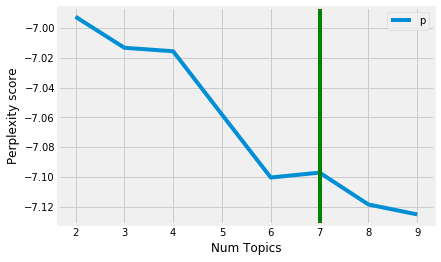

In [93]:
# Show graph
x = range(start1, limit1, step1)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.axvline(x=optimal_numTopics, color='g')
plt.show()

In [94]:

optimal_model = model_list[optimal_numTopics]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.087*"dirty" + 0.080*"place" + 0.074*"unhygienic" + 0.074*"area" + '
  '0.030*"cleanindia" + 0.030*"free" + 0.025*"mission" + 0.015*"part" + '
  '0.013*"even" + 0.013*"govt" + 0.012*"push" + 0.012*"sixwordsstory" + '
  '0.010*"forward" + 0.009*"r" + 0.008*"time" + 0.008*"human" + 0.007*"proud" '
  '+ 0.005*"failure" + 0.005*"myc…" + 0.005*"started"'),
 (1,
  '0.100*"toilet" + 0.033*"people" + 0.028*"work" + 0.018*"target" + 0.017*"…" '
  '+ 0.017*"school" + 0.017*"together" + 0.016*"pledge" + 0.016*"sanitation" + '
  '0.013*"http…" + 0.013*"top" + 0.012*"girl" + 0.012*"construct" + '
  '0.012*"lovewhereyoulive" + 0.012*"safeindia" + 0.010*"till" + '
  '0.009*"planning" + 0.009*"key" + 0.009*"public" + 0.008*"govt"'),
 (2,
  '0.034*"make" + 0.021*"challenge" + 0.020*"indian" + 0.019*"achieve" + '
  '0.014*"campaign" + 0.013*"public" + 0.013*"lead" + 0.012*"since" + '
  '0.011*"address" + 0.010*"issue" + 0.010*"police" + 0.010*"continuing" + '
  '0.009*"improving" + 0.009*"good"

In [95]:
# Get main topic in each document
gamma_df = build_gamma_df(lda_model=optimal_model, corpus0=sbdf['Tweet_text'])
#gamma_df.iloc[:8,:8]

row0 = gamma_df.values.tolist()
row=[]
for i in range(len(row0)):
    row1 = list(enumerate(row0[i]))
    row1_y = [y for (x,y) in row1]
    max_propn = sorted(row1_y, reverse=True)[0]
    row2 = [(i, x, y) for (x, y) in row1 if y==max_propn]
    row.append(row2)

row[0:10]

[[(0, 7, 0.7778183817863464)],
 [(1, 0, 0.6538860201835632)],
 [(2, 2, 0.6312015056610107)],
 [(3, 2, 0.8913124799728394)],
 [(4, 5, 0.8360470533370972)],
 [(5, 7, 0.8729426264762878)],
 [(6, 4, 0.6481317281723022)],
 [(7, 5, 0.7746784090995789)],
 [(8, 3, 0.6503478288650513)],
 [(9, 4, 0.7798486351966858)]]

In [96]:
sent_topics_df = pd.DataFrame()
for row1 in row:
    for (doc_num, topic_num, prop_topic) in row1:
        wp = optimal_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(doc_num), int(topic_num), 
                                                          round(prop_topic,4), 
                                                          topic_keywords]), 
                                                       ignore_index=True)
    
sent_topics_df.columns = ['Doc_num', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']    
sent_topics_df.iloc[:10, :]

,Doc_num,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,0.0,7.0,0.7778,"…, amp, drive, campaign, cleanliness, like, cl..."
1,1.0,0.0,0.6539,"dirty, place, area, unhygienic, cleanindia, fr..."
2,2.0,2.0,0.6312,"make, challenge, indian, achieve, campaign, pu..."
3,3.0,2.0,0.8913,"make, challenge, indian, achieve, campaign, pu..."
4,4.0,5.0,0.8360,"sanitation, cleaner, …, end, clean, town, keep..."
5,5.0,7.0,0.8729,"…, amp, drive, campaign, cleanliness, like, cl..."
6,6.0,4.0,0.6481,"u, clean, across, initiative, …, day, get, fir..."
7,7.0,5.0,0.7747,"sanitation, cleaner, …, end, clean, town, keep..."
8,8.0,3.0,0.6503,"garbage, city, waste, dream, best, wastemanage..."
9,9.0,4.0,0.7798,"u, clean, across, initiative, …, day, get, fir..."


In [97]:
# Add original text to the end of the output
contents = pd.Series(sbdf['cleanedText'])
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#return(sent_topics_df)
sent_topics_df.columns = ['Doc_num', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'contents']
sent_topics_df.iloc[:8,:]

,Doc_num,Dominant_Topic,Perc_Contribution,Topic_Keywords,contents
0,0.0,7.0,0.7778,"…, amp, drive, campaign, cleanliness, like, cl...",[lakh loo built village month]
1,1.0,0.0,0.6539,"dirty, place, area, unhygienic, cleanindia, fr...",[human life inwords swachhbharatddn piyushgoyal]
2,2.0,2.0,0.6312,"make, challenge, indian, achieve, campaign, pu...",[becho make kabadiwala]
3,3.0,2.0,0.8913,"make, challenge, indian, achieve, campaign, pu...",[agra police us campaign arrest urinating public]
4,4.0,5.0,0.8360,"sanitation, cleaner, …, end, clean, town, keep...",[bhopal aim opendefecationfree city year end s...
5,5.0,7.0,0.8729,"…, amp, drive, campaign, cleanliness, like, cl...",[bill introduced give legal teeth drive]
6,6.0,4.0,0.6481,"u, clean, across, initiative, …, day, get, fir...",[clean pollutionfree priority]
7,7.0,5.0,0.7747,"sanitation, cleaner, …, end, clean, town, keep...",[coimbatrore engineer invited toilet construct...


In [98]:
tokens = sbdf['cleanedText'].astype(str).apply(lambda x: x.split())
   

In [99]:
dictionary = corpora.Dictionary(tokens)

doc_term_matrix = [dictionary.doc2bow(term) for term in tokens]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100,
                chunksize=1000, passes=50)

lda_model.print_topics()

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.094459 -0.122775       1        1  29.102043
3     -0.120930  0.107860       2        1  26.668247
1      0.109495 -0.036937       3        1  23.325588
2      0.105893  0.051852       4        1  20.904131, topic_info=     Category       Freq               Term      Total  loglift  logprob
term                                                                    
449   Default  75.000000              place  75.000000  30.0000  30.0000
450   Default  71.000000         unhygienic  71.000000  29.0000  29.0000
448   Default  68.000000              dirty  68.000000  28.0000  28.0000
445   Default  26.000000              video  26.000000  27.0000  27.0000
267   Default  26.000000     mycleanindia']  26.000000  26.0000  26.0000
447   Default  46.000000             area']  46.000000  25.0000  25.0000
454   Default  25.000000               area  25.000000  24.0000  24.0000
444   Default  23.000000           tutorial  23.000000  23.0000  23.0000
40    Default  31.000000             toilet  31.000000  22.0000  22.0000
455   Default  24.000000       cleanindia']  24.000000  21.0000  21.0000
443   Default  22.000000             forget  22.000000  20.0000  20.0000
442   Default  22.000000         aapbreakup  22.000000  19.0000  19.0000
285   Default  27.000000               take  27.000000  18.0000  18.0000
1323  Default  50.000000                …']  50.000000  17.0000  17.0000
463   Default  12.000000           together  12.000000  16.0000  16.0000
146   Default  10.000000               free  10.000000  15.0000  15.0000
458   Default  12.000000      keepindiatidy  12.000000  14.0000  14.0000
459   Default  12.000000   lovewhereyoulive  12.000000  13.0000  13.0000
461   Default  12.000000             pledge  12.000000  12.0000  12.0000
462   Default  12.000000        safeindia']  12.000000  11.0000  11.0000
61    Default   8.000000                u']   8.000000  10.0000  10.0000
914   Default   8.000000              via']   8.000000   9.0000   9.0000
371   Default  14.000000               work  14.000000   8.0000   8.0000
155   Default   9.000000               ['']   9.000000   7.0000   7.0000
362   Default   6.000000              offer   6.000000   6.0000   6.0000
363   Default   6.000000          regularly   6.000000   5.0000   5.0000
364   Default   6.000000          shramdaan   6.000000   4.0000   4.0000
460   Default  16.000000             people  16.000000   3.0000   3.0000
361   Default   6.000000           ['wecare   6.000000   2.0000   2.0000
228   Default   6.000000                top   6.000000   1.0000   1.0000
...       ...        ...                ...        ...      ...      ...
1307   Topic4   2.830150               love   3.356802   1.3946  -5.8134
937    Topic4   2.830047               rd']   3.356807   1.3945  -5.8134
1181   Topic4   2.829881               hold   3.356817   1.3945  -5.8135
134    Topic4   2.164211             worker   2.690876   1.3474  -6.0816
837    Topic4   2.164204           download   2.690877   1.3474  -6.0816
978    Topic4   2.164197               true   2.690877   1.3474  -6.0816
876    Topic4   2.164190          ['fulfill   2.690878   1.3474  -6.0816
879    Topic4   2.164190                per   2.690878   1.3474  -6.0816
226    Topic4   2.164189             figure   2.690878   1.3474  -6.0816
227    Topic4   2.164189              north   2.690878   1.3474  -6.0816
130    Topic4   2.164181               join   2.690878   1.3474  -6.0817
1184   Topic4   2.163851              right   2.690897   1.3472  -6.0818
840    Topic4   4.869743            towards   6.778831   1.2345  -5.2707
835    Topic4   5.584098        cleanliness   8.121637   1.1906  -5.1338
867    Topic4   4.170311                 go   6.098550   1.1852  -5.4257
750    Topic4   3.536590               help   5.438819   1.1348  -5.5905
1354   Topic4   3.525076            http…']   5.422686  